In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [31]:
train_data=pd.read_csv(r'C:\Users\admin\mypythonstuff\Quantrade\train_processed.csv')
train_data.columns = train_data.columns.str.lower()
test_data=pd.read_csv(r'C:\Users\admin\mypythonstuff\Quantrade\final_test.csv')
test_data.columns=test_data.columns.str.lower()

Preprcoessing of Data and Feature Engineering

In [32]:
def load_and_preprocess_training_data(df):
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date
    df = df.sort_values('date')
    
    # Calculate additional features
    df['price_range'] = df['high'] - df['low']
    df['price_change'] = df['close'] - df['open']
    df['price_change_pct'] = np.where(df['open'] != 0, 
                                     (df['close'] - df['open']) / df['open'] * 100,
                                     0)
    df['vol_change_pct'] = df['volume'].pct_change() * 100
    df['vol_change_pct'] = df['vol_change_pct'].clip(-1000, 1000)  # Clip extreme values

    
    # Calculate moving averages
    df['MA5'] = df['close'].rolling(window=5,min_periods=1).mean()
    df['MA20'] = df['close'].rolling(window=20,min_periods=1).mean()
    
    # Calculate volatility (20-day rolling standard deviation)
    df['volatility'] = df['close'].rolling(window=20).std()
    
    # Calculate RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Handle missing values
    df = df.ffill()
    df = df.fillna(0)
    
    # Select features for anomaly detection
    features = ['price_change_pct', 'vol_change_pct', 'price_range', 
               'volatility', 'RSI']

    for feature in features:
        df[feature] = df[feature].clip(-1e10, 1e10)
    
    # Scale the features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[features]),
        columns=features,
        index=df.index
    )
    
    return df, df_scaled, features, scaler 

# Use the updated function
df, df_scaled, features, scaler = load_and_preprocess_training_data(train_data)


Information about the dataset

In [33]:
print("Dataset Info:")
print(df.info())
print("\nFeature Statistics:")
print(df[features].describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24332 entries, 0 to 24331
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              24332 non-null  datetime64[ns]
 1   open              24332 non-null  float64       
 2   high              24332 non-null  float64       
 3   low               24332 non-null  float64       
 4   close             24332 non-null  float64       
 5   volume            24332 non-null  float64       
 6   dividends         24332 non-null  float64       
 7   stock splits      24332 non-null  float64       
 8   price_range       24332 non-null  float64       
 9   price_change      24332 non-null  float64       
 10  price_change_pct  24332 non-null  float64       
 11  vol_change_pct    24332 non-null  float64       
 12  MA5               24332 non-null  float64       
 13  MA20              24332 non-null  float64       
 14  volatili

Defining and Training the Model

In [34]:
def train_anomaly_detector(df_scaled):
    # Initialize and train Isolation Forest
    iso_forest = IsolationForest(
        contamination=0.1,  
        random_state=42,
        n_jobs=-1
    )

    # Fit the model
    iso_forest.fit(df_scaled)

    return iso_forest

#Train the model
model = train_anomaly_detector(df_scaled)

In [35]:
# Get predictions for training data
train_predictions = model.predict(df_scaled)

Visualization of the data

In [36]:
def plot_anomalies_by_year(df, anomalies, year):
    # Filter data for the specified year
    year_data = df[df['date'].dt.year == year].copy()
    
    if len(year_data) == 0:
        print(f"No data available for year {year}")
        return
    
    # Get the corresponding anomalies for this year's data
    year_indices = year_data.index
    year_anomalies = pd.Series(anomalies, index=df.index).loc[year_indices]
    
    # Remove extreme outliers using z-score
    z_scores = np.abs(stats.zscore(year_data['close']))
    year_data = year_data[z_scores < 3]
    year_anomalies = year_anomalies[z_scores < 3]
    
    plt.figure(figsize=(15, 7))
    
    # Plot the stock prices
    sns.lineplot(data=year_data, x='date', y='close', label='Close Price')
    
    # Plot anomalies
    anomaly_points = year_data[year_anomalies == -1]
    if len(anomaly_points) > 0:
        plt.scatter(anomaly_points['date'], anomaly_points['close'], 
                   color='red', label='Anomaly', zorder=5)
    
    plt.title(f'Stock Price Anomalies - {year}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

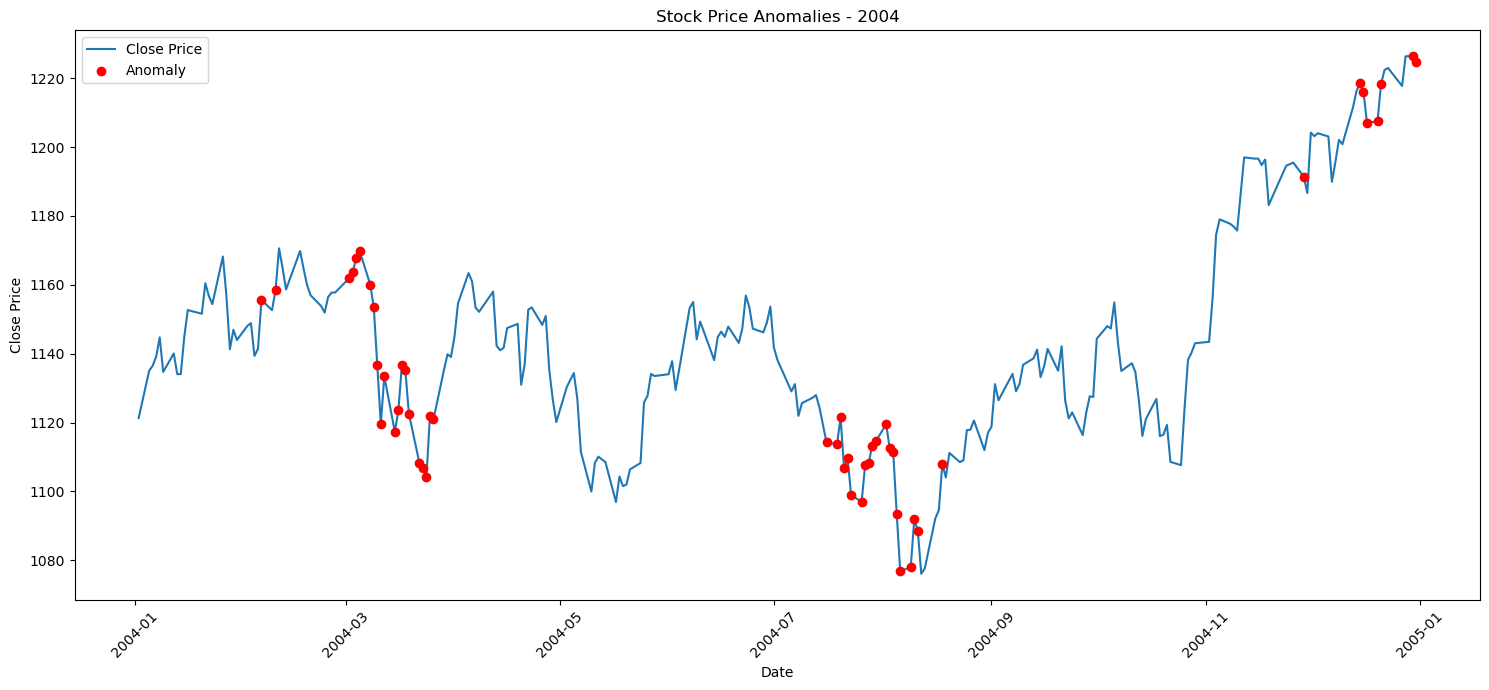

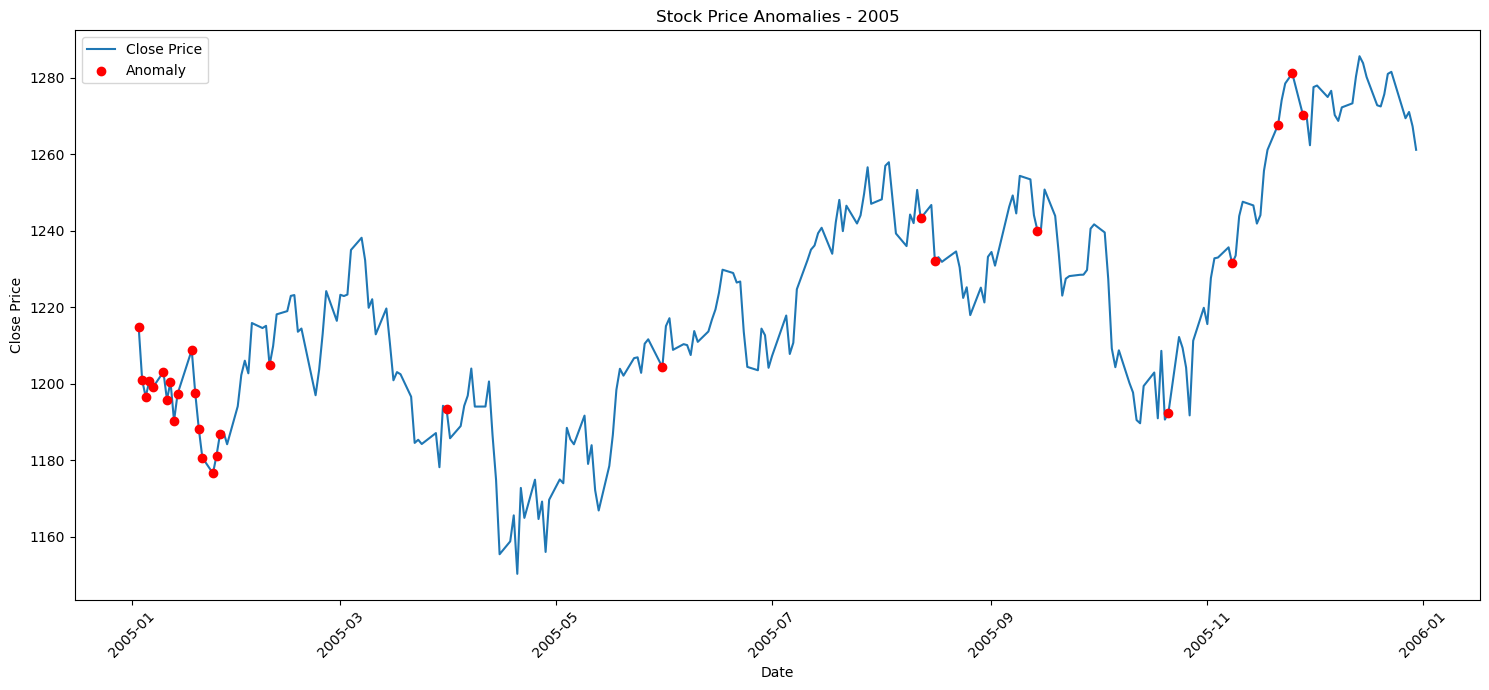

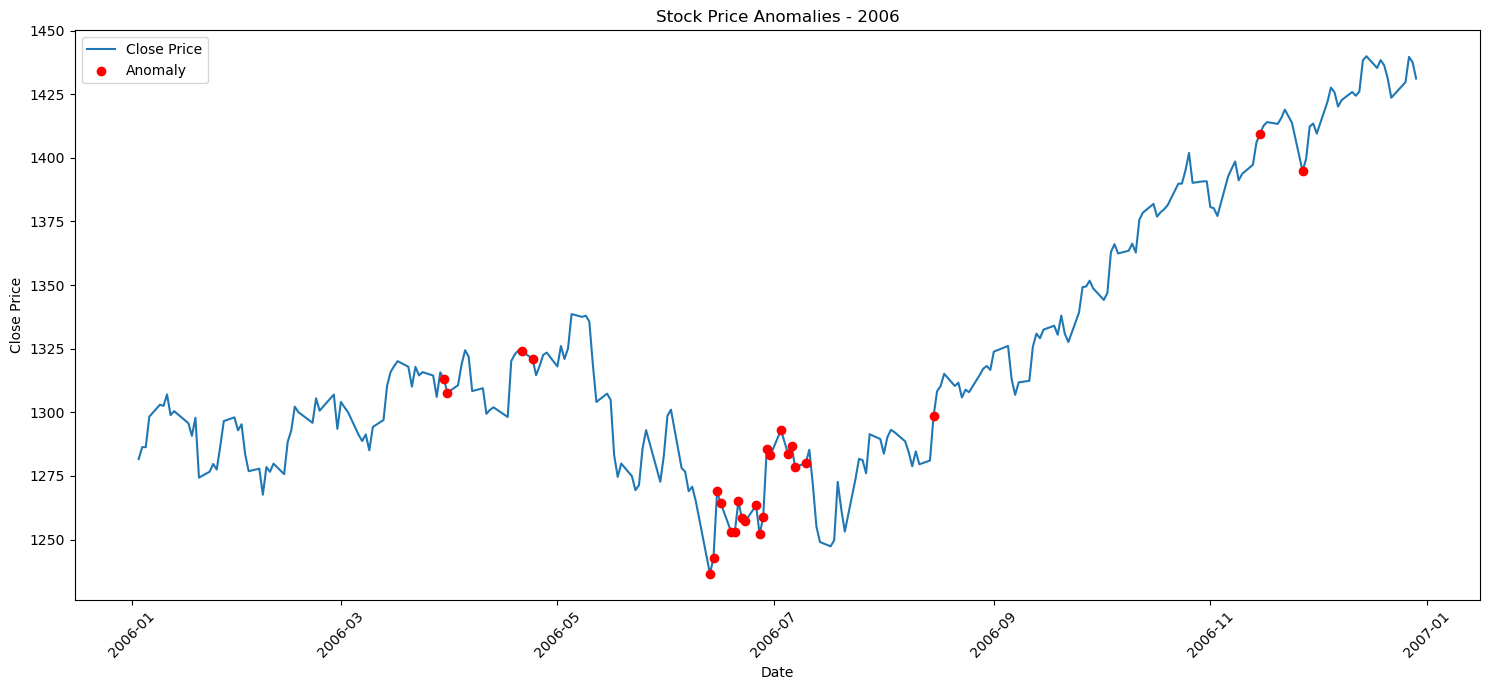

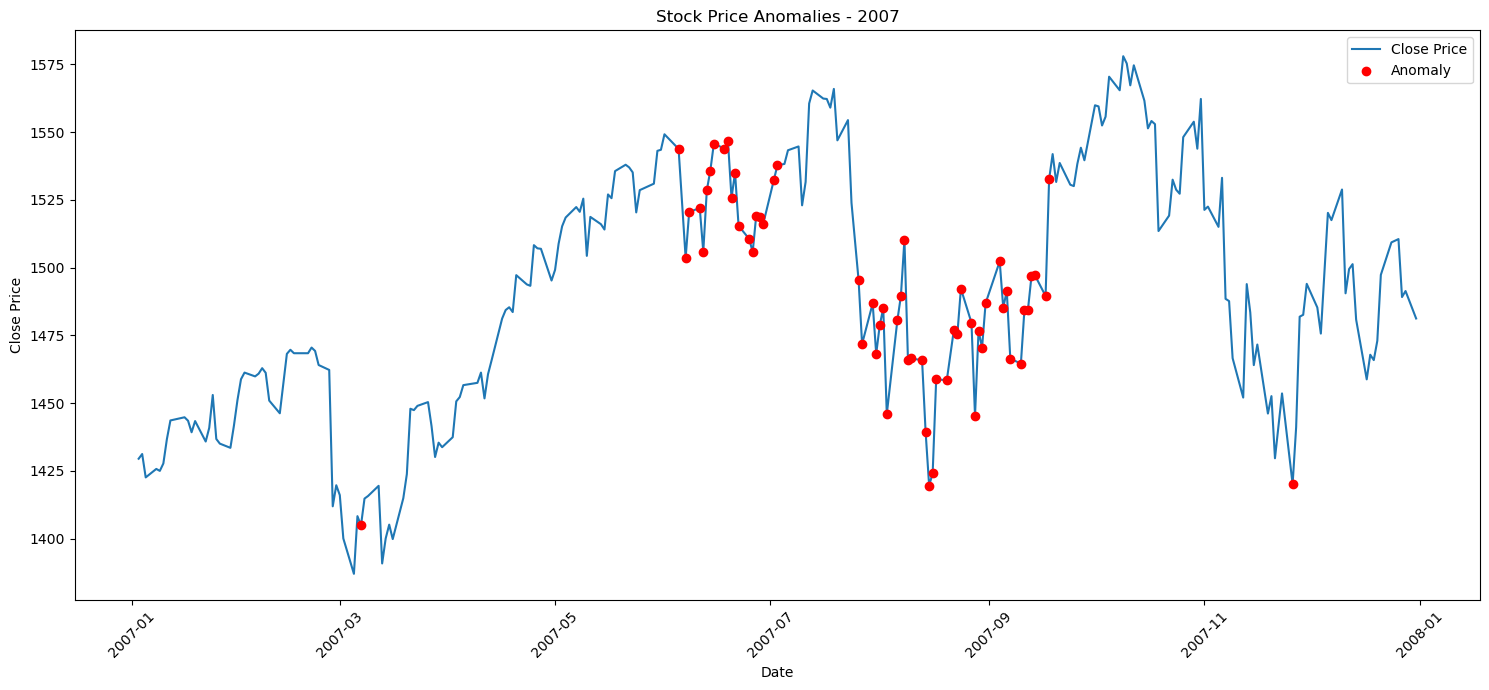

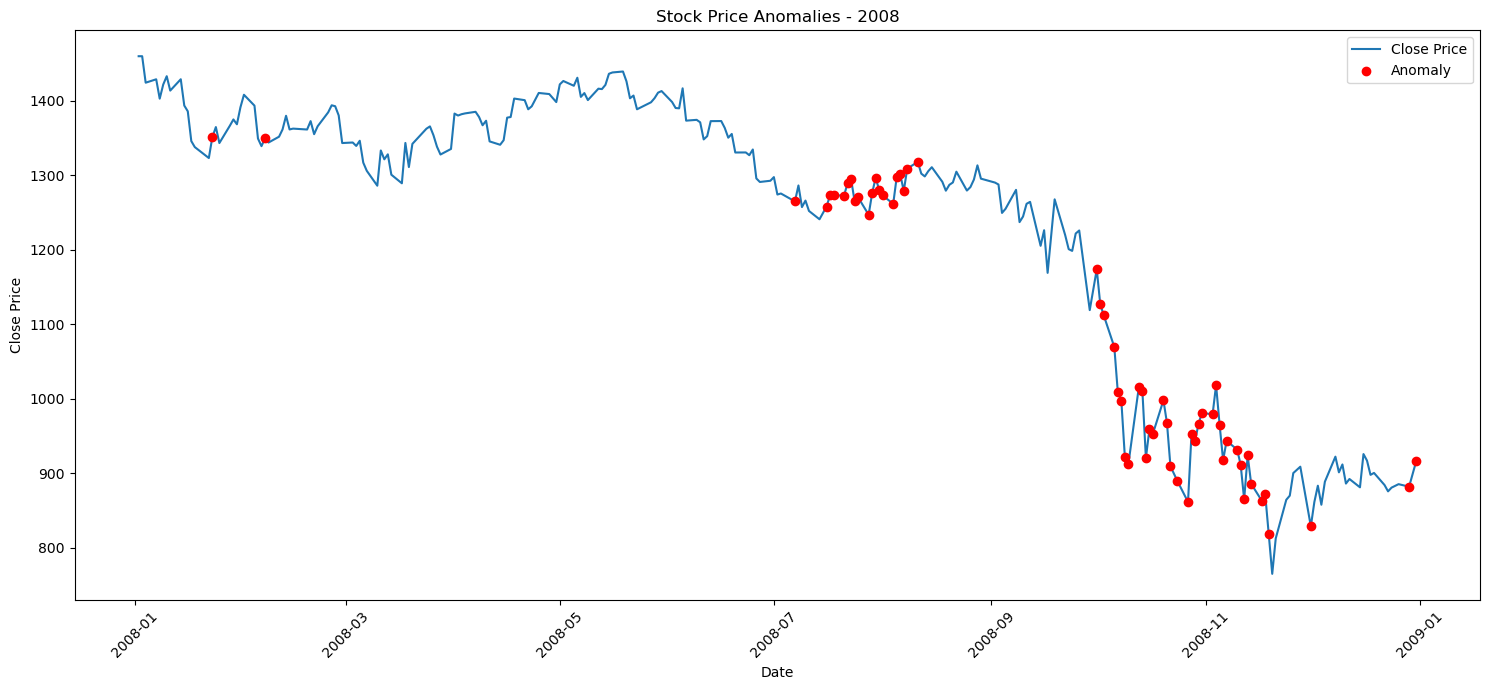

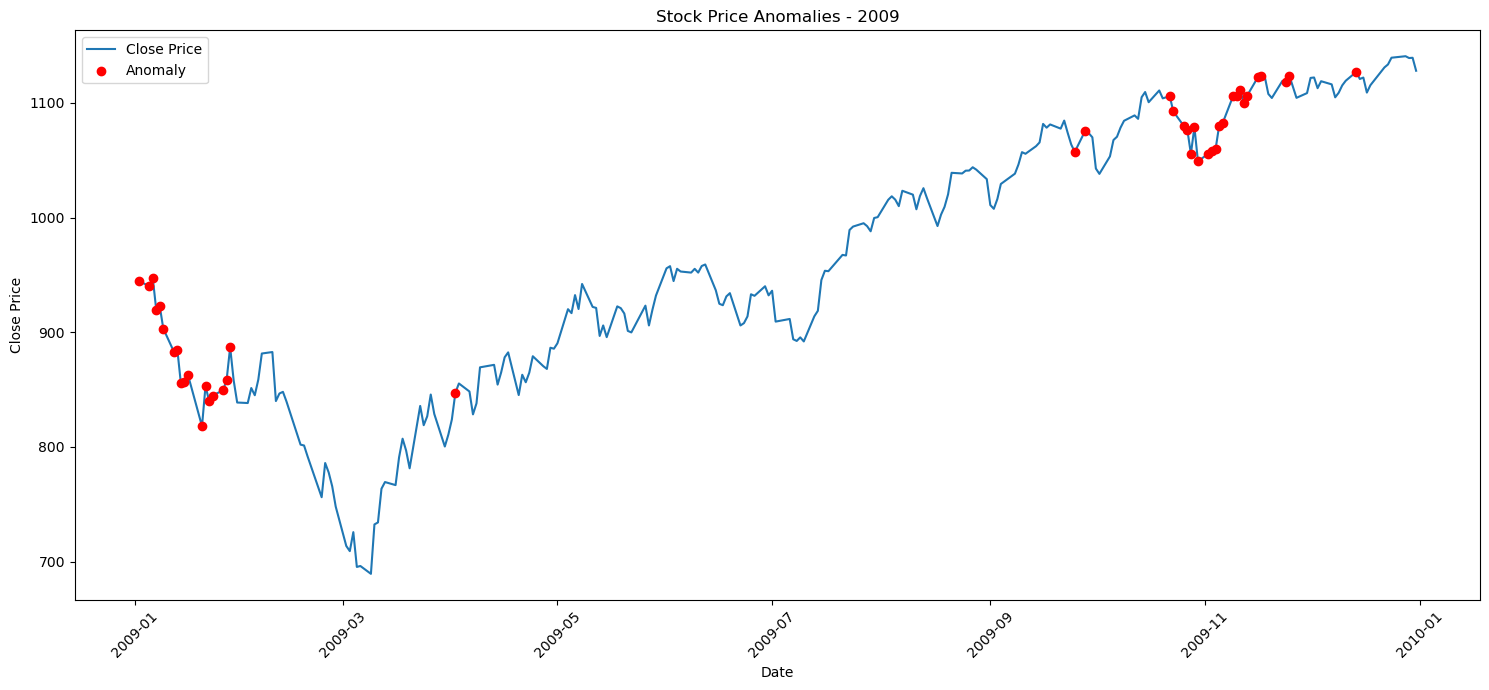

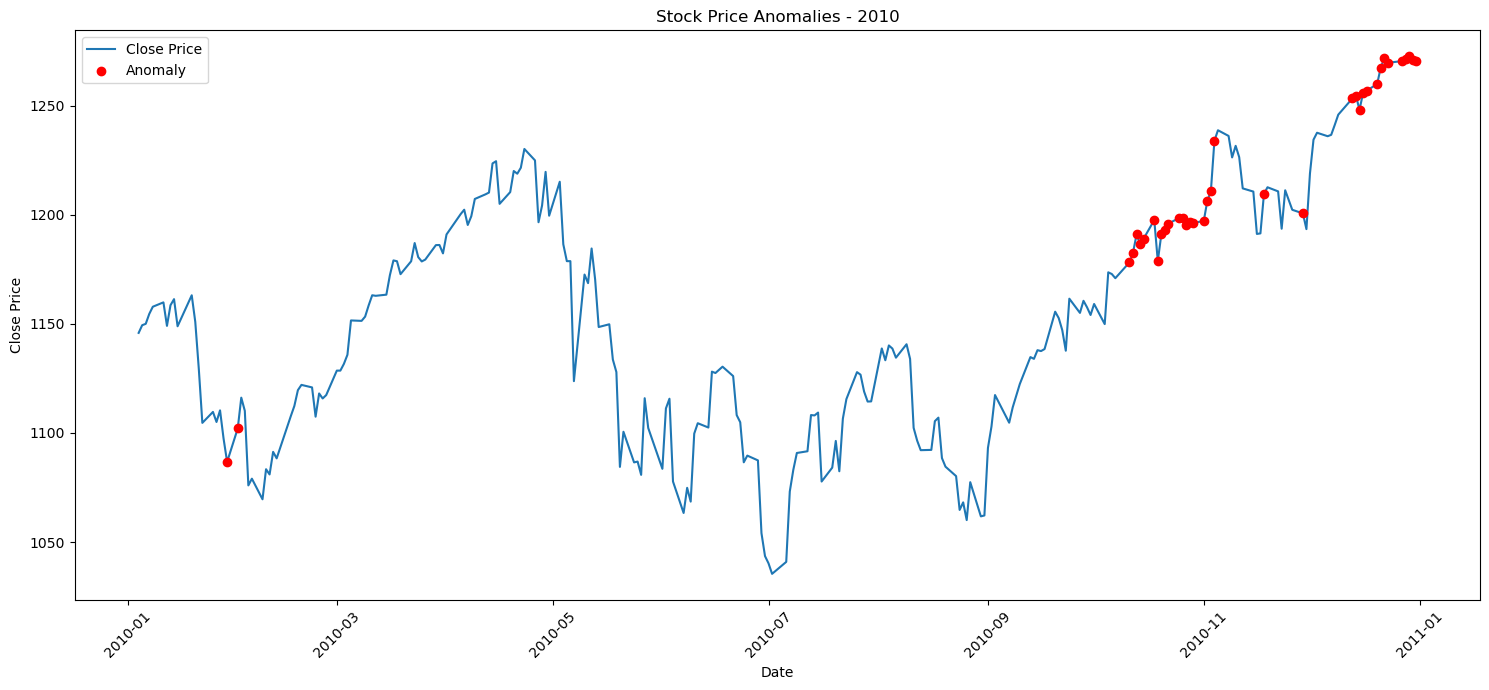

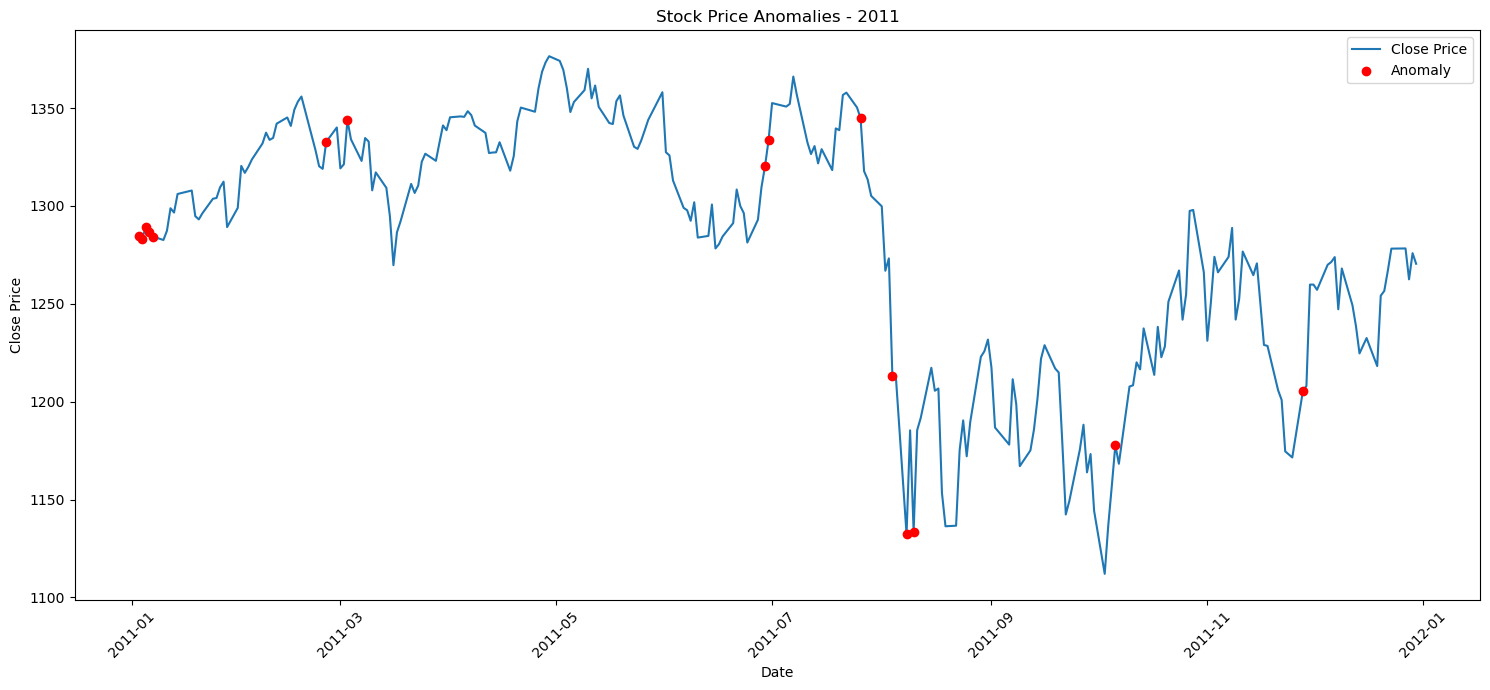

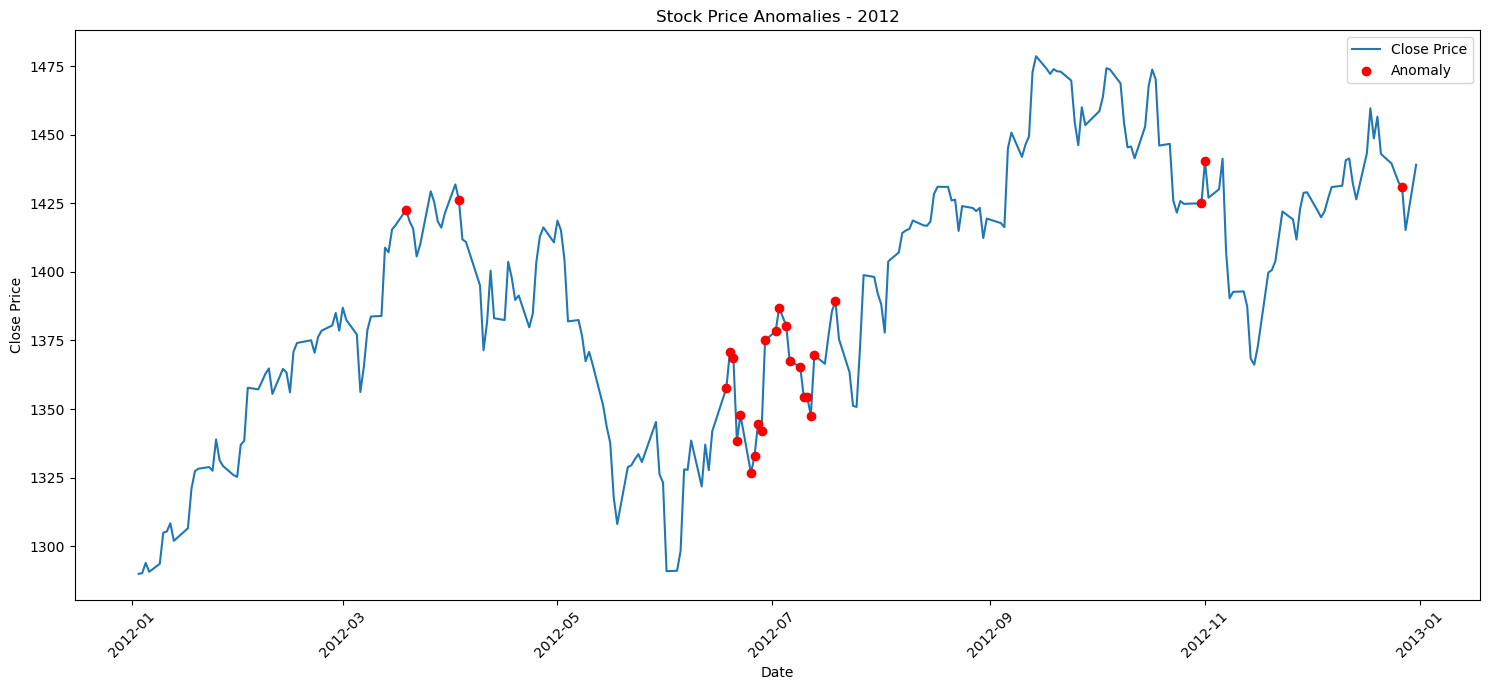

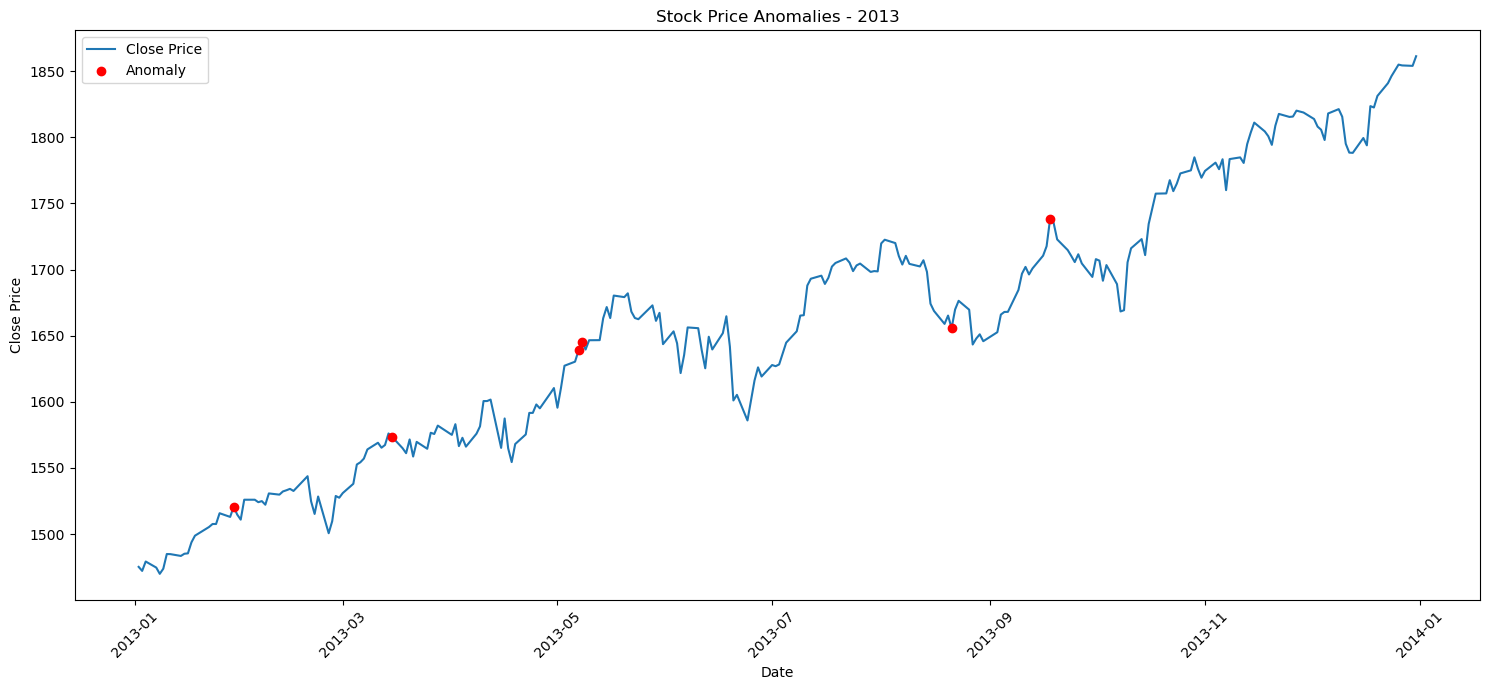

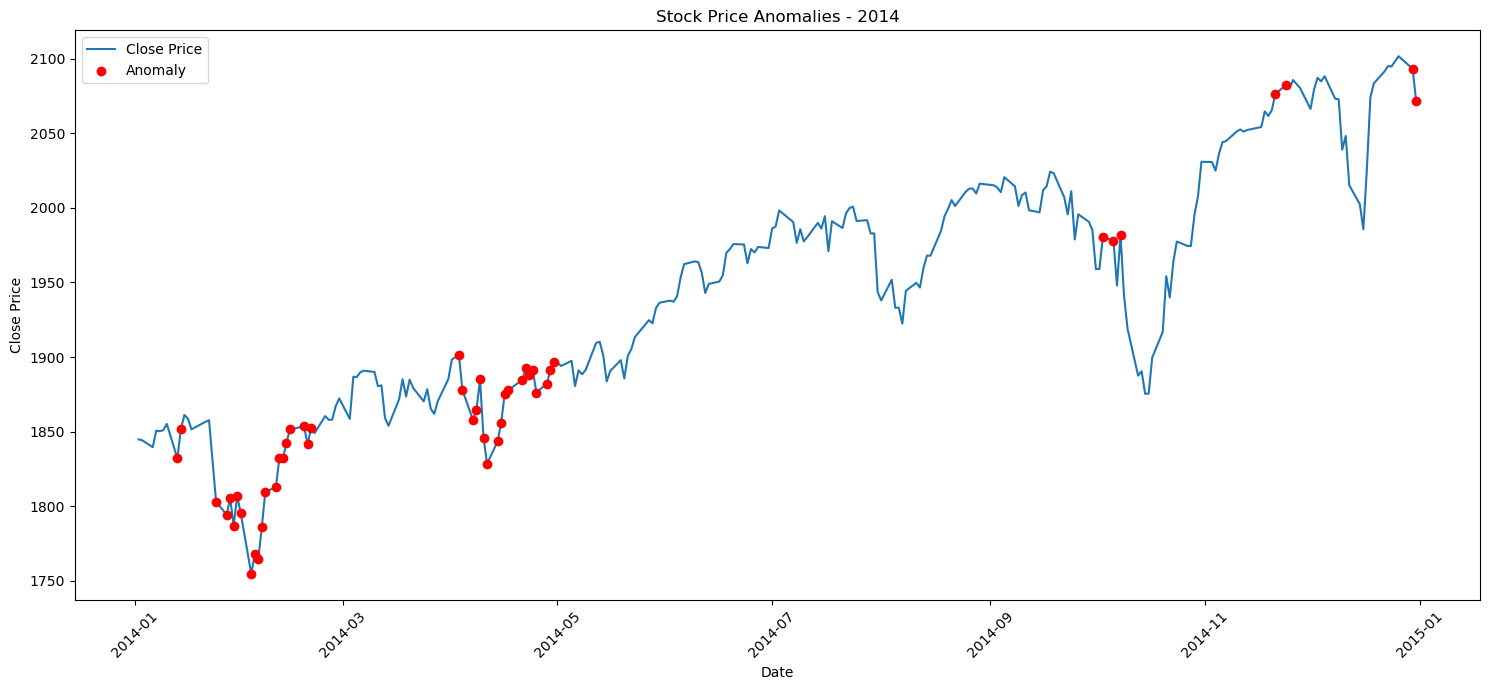

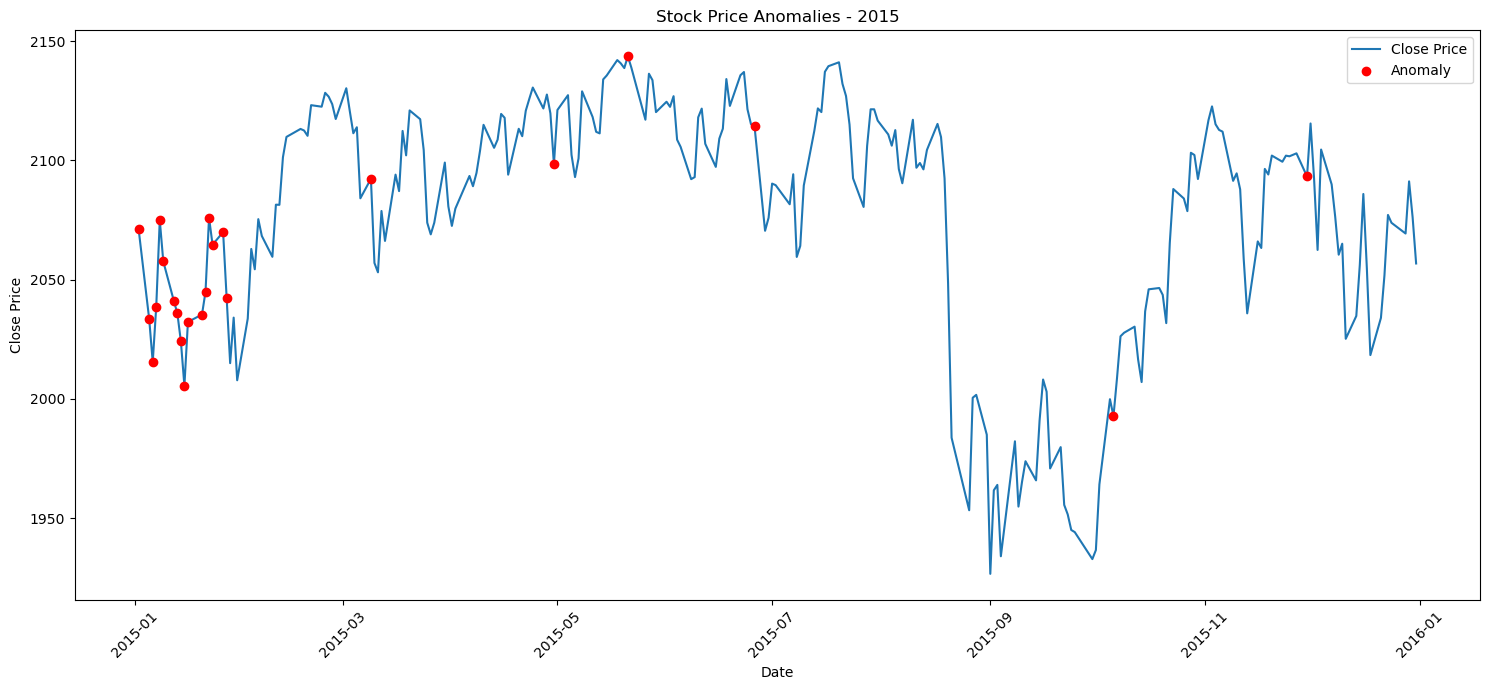

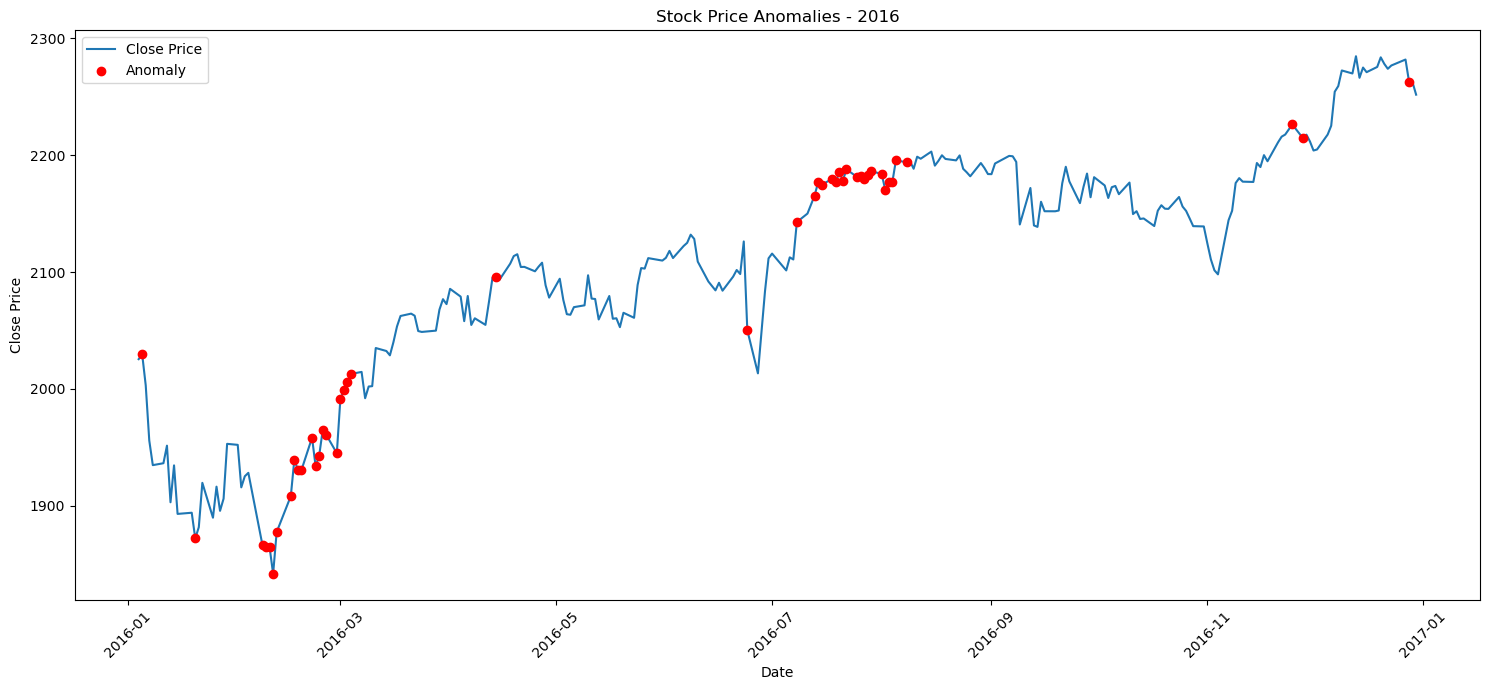

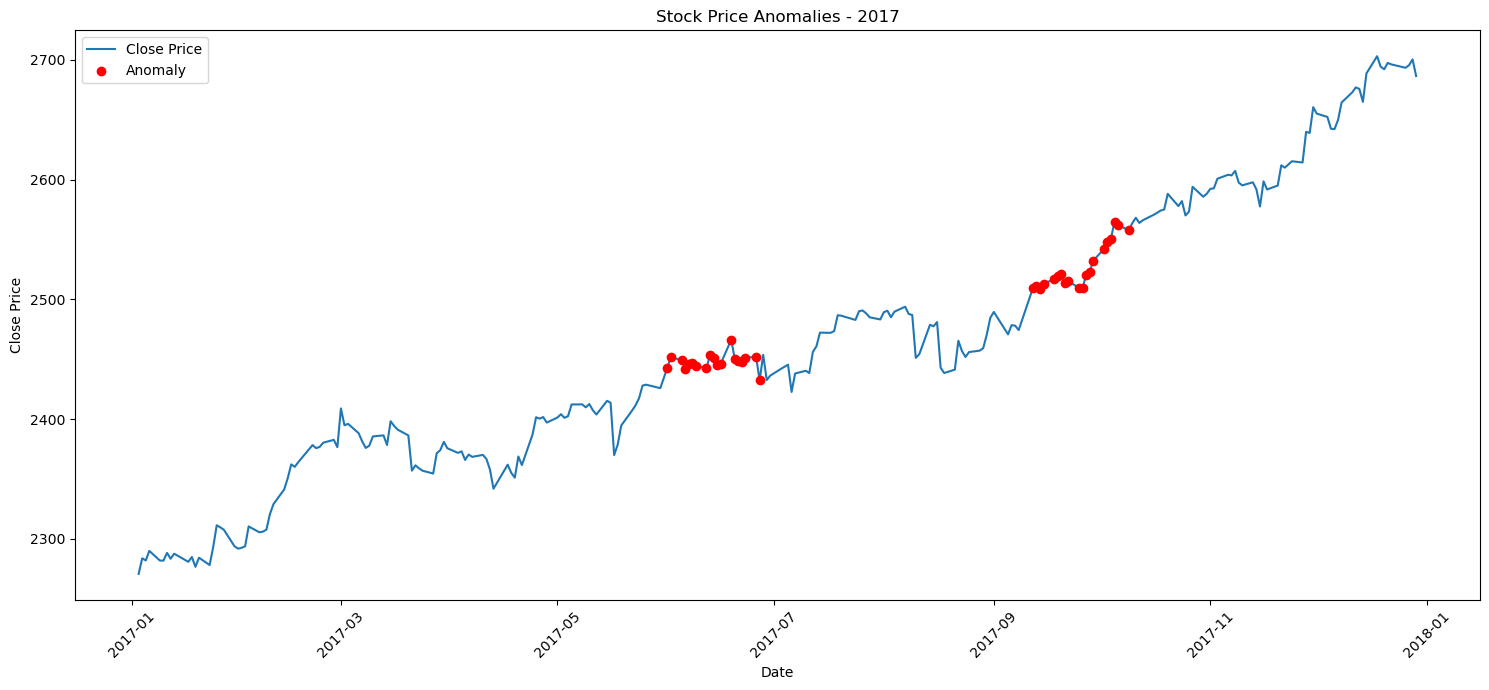

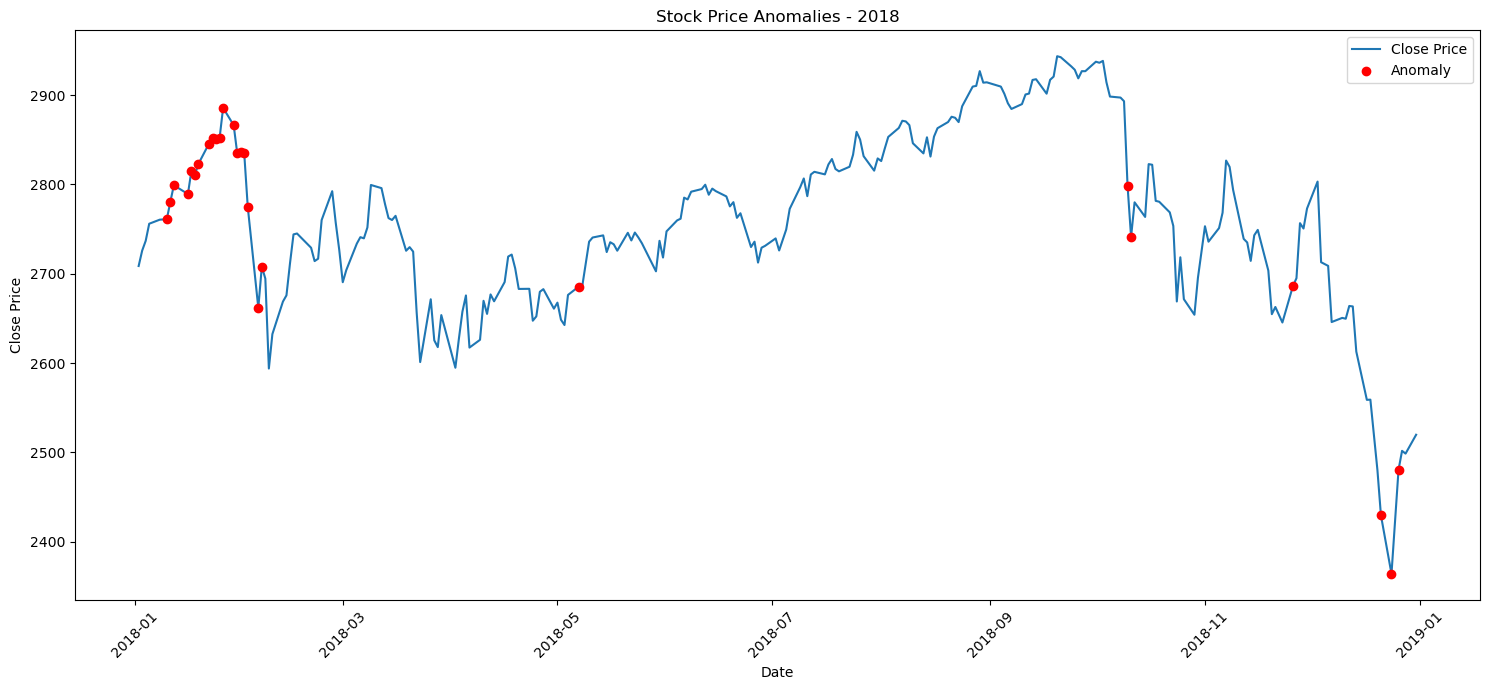

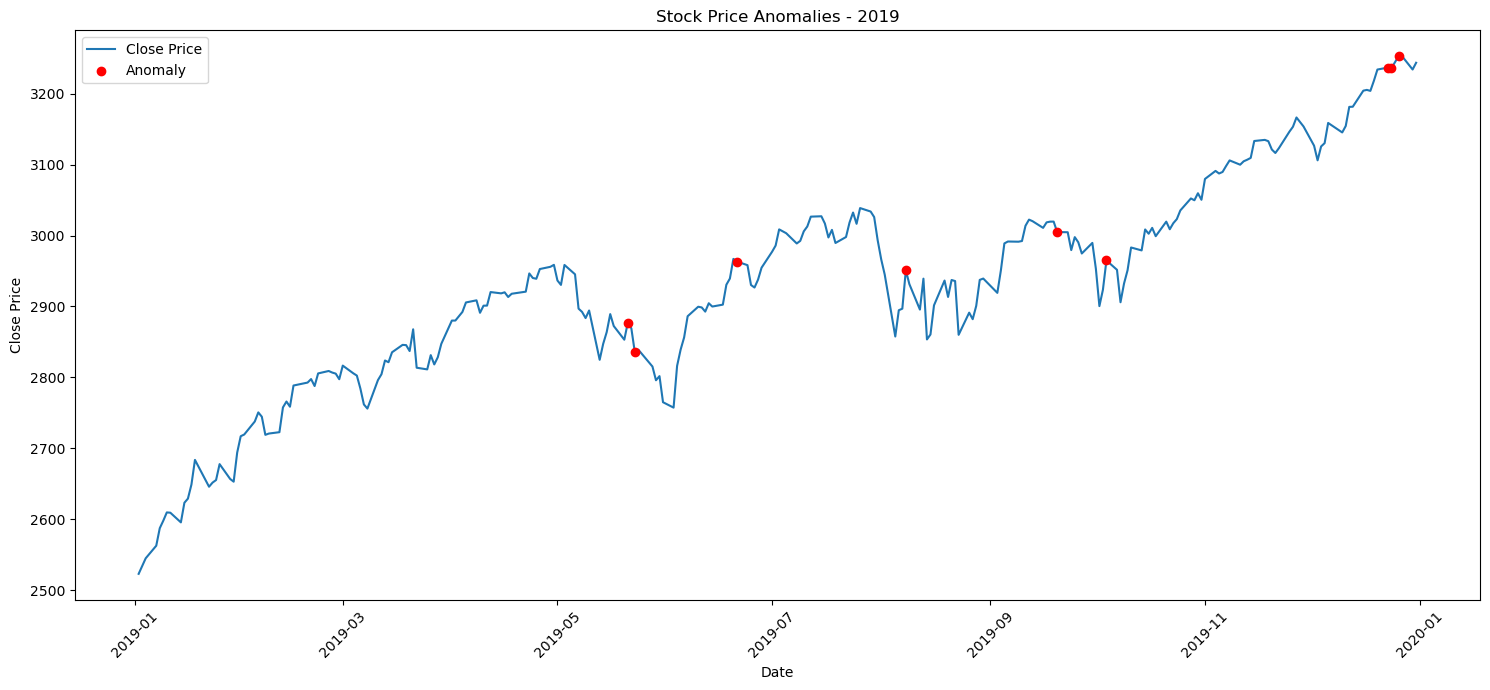

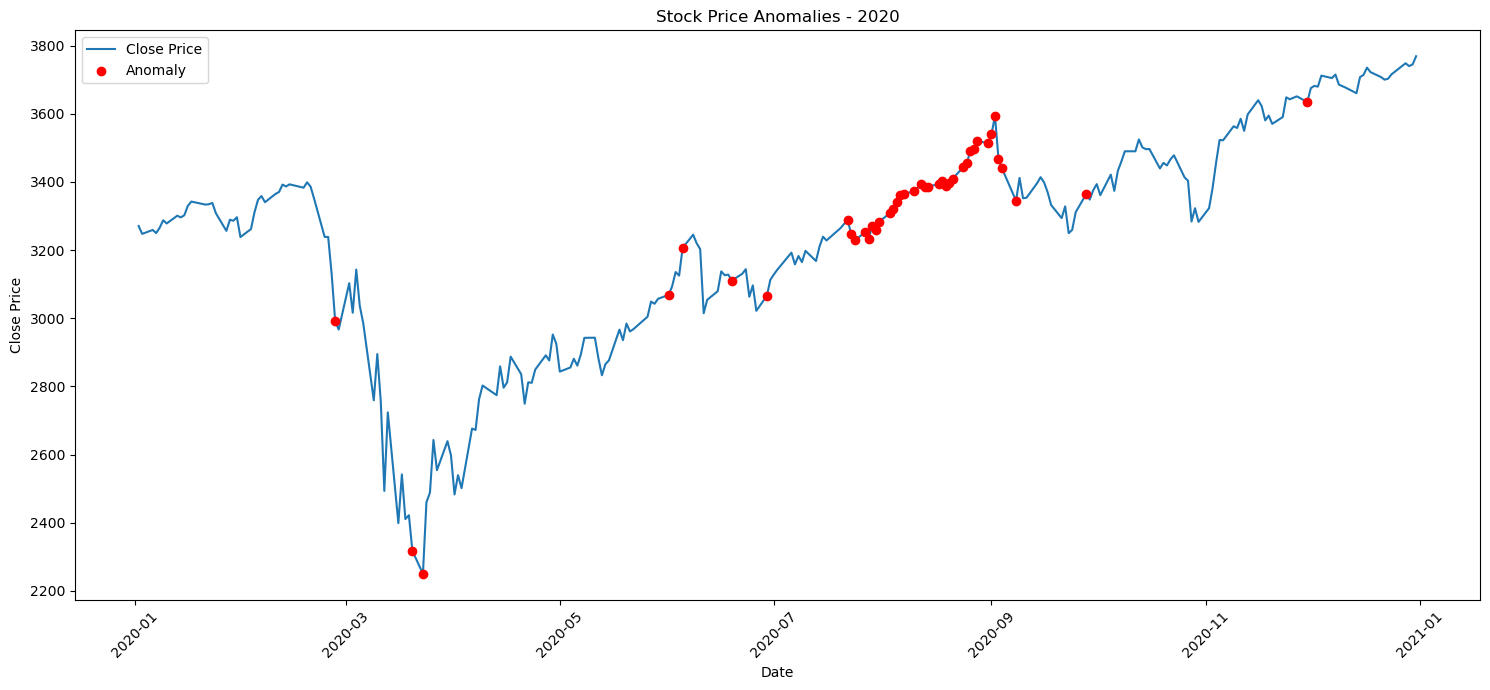

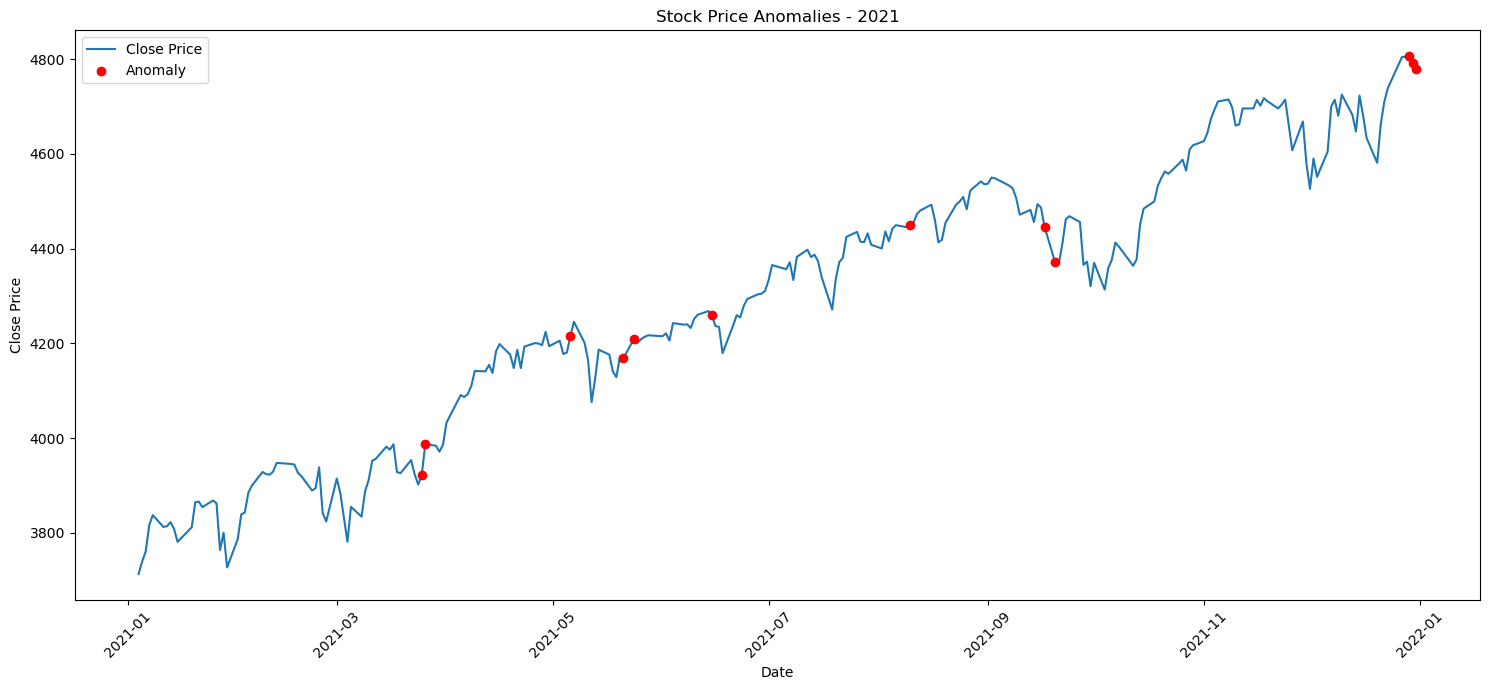

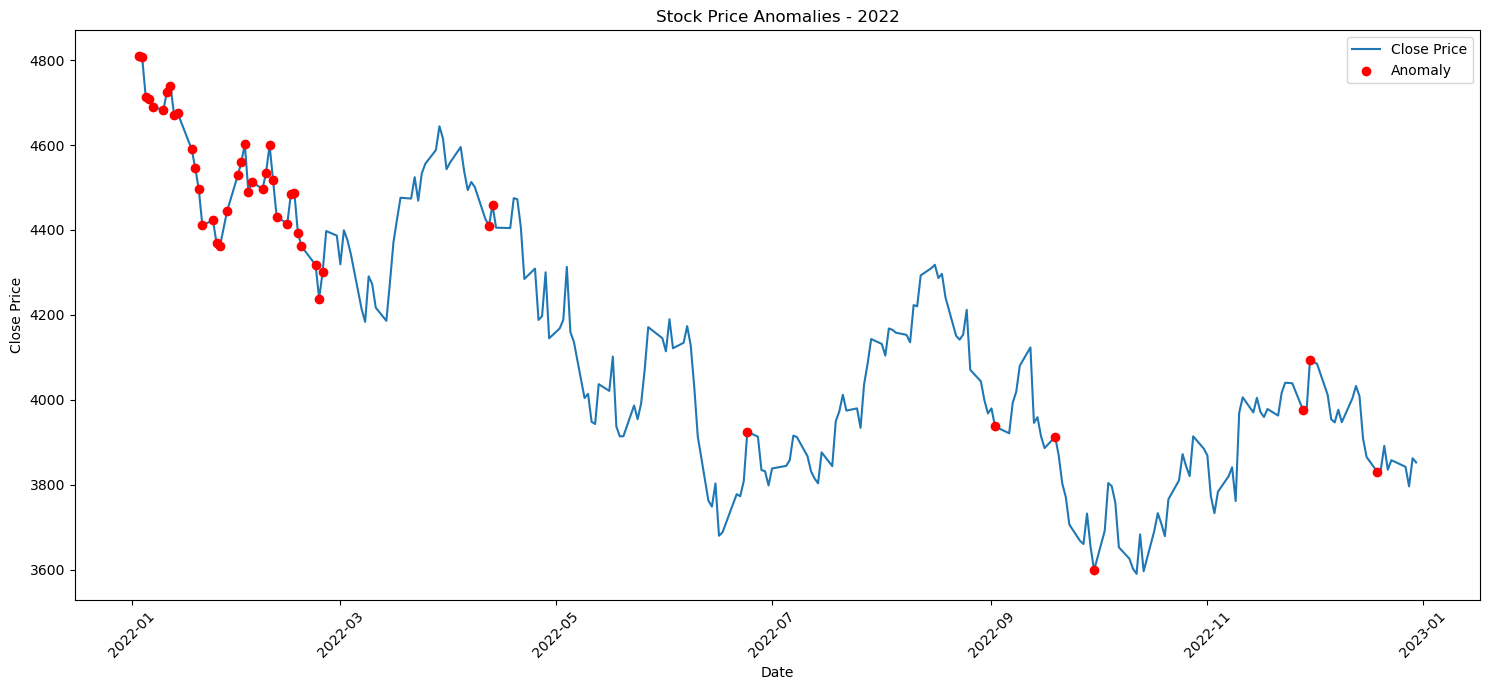

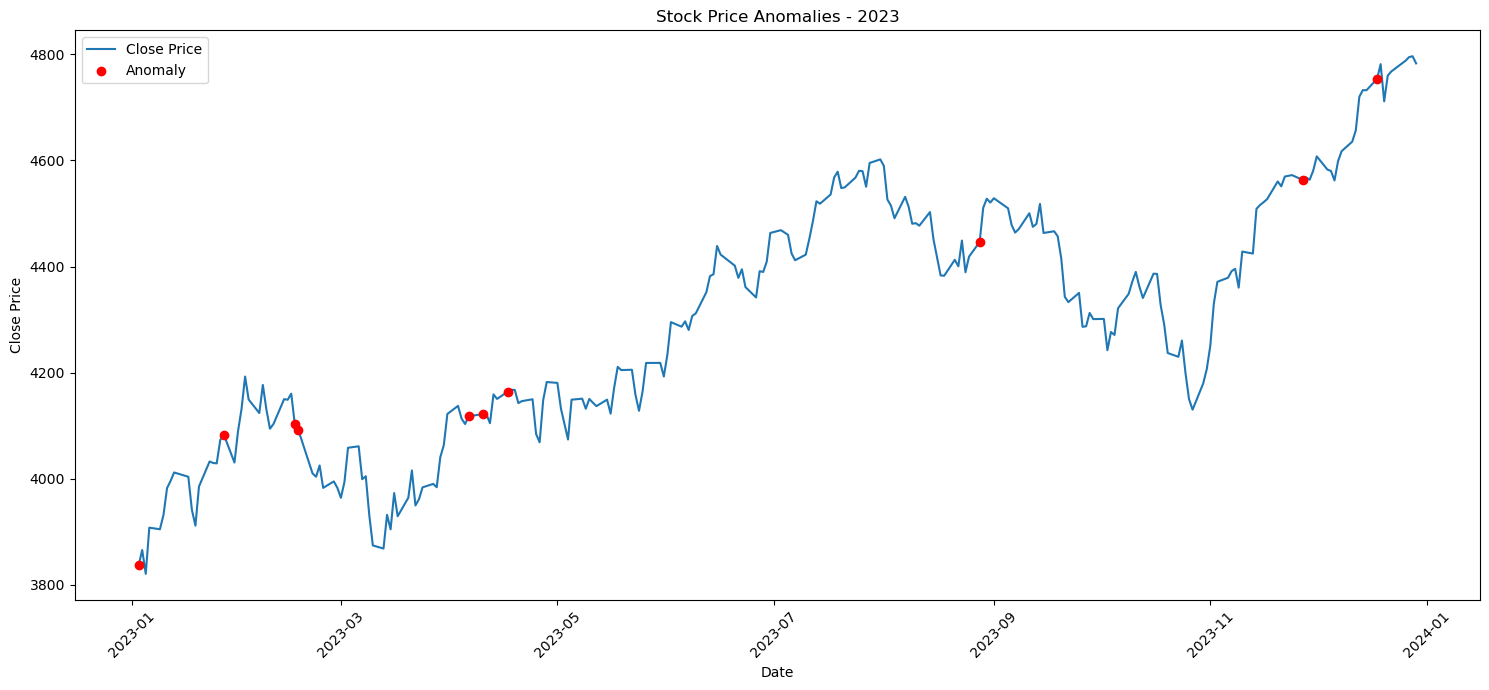

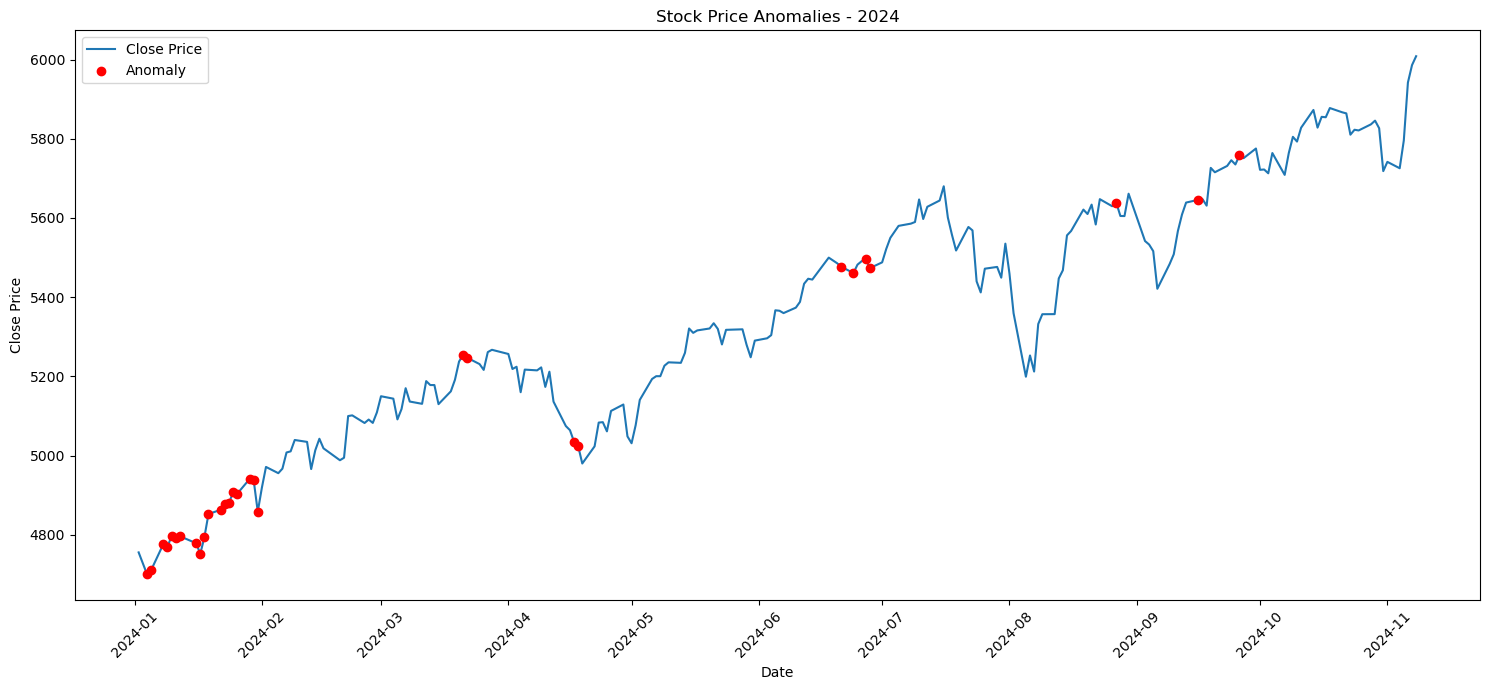

In [37]:
years = df['date'].dt.year
years = years[(years >= 2004) & (years <= 2024)].unique()

# Plot anomalies for each year
for year in sorted(years):
    plot_anomalies_by_year(df, train_predictions, year)

Using the test data to detect anomalies

In [38]:
def process_test_data(test_df, model, scaler, features):
    # Process each symbol separately
    results = []
    
    for symbol in test_df['symbol'].unique():
        symbol_data = test_df[test_df['symbol'] == symbol].copy()
        
        # Skip if not enough data
        if len(symbol_data) < 20:
            continue
            
        # Calculate features
        symbol_data['price_range'] = symbol_data['high'] - symbol_data['low']
        symbol_data['price_change'] = symbol_data['close'] - symbol_data['open']
        symbol_data['price_change_pct'] = np.where(
            symbol_data['open'] != 0,
            (symbol_data['close'] - symbol_data['open']) / symbol_data['open'] * 100,
            0
        )
        
        # Calculate volume changes with proper handling
        symbol_data['vol_change_pct'] = symbol_data['volume'].pct_change().fillna(0) * 100
        symbol_data['vol_change_pct'] = symbol_data['vol_change_pct'].clip(-1000, 1000)
        
        # Calculate other technical indicators
        symbol_data['volatility'] = symbol_data['close'].rolling(window=20, min_periods=1).std()
        
        delta = symbol_data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
        rs = gain / loss
        symbol_data['RSI'] = 100 - (100 / (1 + rs.replace(np.inf, np.nan)).fillna(0))
        
        # Handle missing values
        symbol_data = symbol_data.fillna(method='ffill').fillna(0)
        
        # Clip extreme values
        for feature in features:
            symbol_data[feature] = symbol_data[feature].clip(-1e10, 1e10)
        
        # Scale features
        scaled_features = scaler.transform(symbol_data[features])
        
        # Predict anomalies
        predictions = model.predict(scaled_features)
        
        # Add anomalies to results
        anomalies = symbol_data[predictions == -1][['date', 'symbol']]
        results.append(anomalies)
    
    # Combine results
    if results:
        return pd.concat(results)
    else:
        return pd.DataFrame(columns=['date', 'symbol'])

anomalies_df = process_test_data(test_data, model, scaler, features)

In [42]:
anomalies_df.to_csv(r'C:\Users\admin\mypythonstuff\Quantrade\test_result.csv.', index=False) 
